The following is a simple proof of concept code to calculate catchment areas using the Friction Surface.

From Reem: We already have and will share, but our 3 priority sites will be: Province of Bohol; Baguio City; and Maguidanao (BARMM)

In [1]:
import os, sys
import geopandas as gpd
import pandas as pd
import rasterio as rio
import numpy as np
from shapely.geometry import Point
import skimage.graph as graph

In [2]:
sys.path.append('/home/wb514197/Repos/gostrocks/src') # gostrocks is used for some basic raster operations (clip and standardize)
sys.path.append('/home/wb514197/Repos/GOSTNets_Raster/src') # gostnets_raster has functions to work with friction surface
sys.path.append('/home/wb514197/Repos/GOSTnets') # it also depends on gostnets for some reason
sys.path.append('/home/wb514197/Repos/INFRA_SAP') # only used to save some raster results

In [3]:
import GOSTRocks.rasterMisc as rMisc
import GOSTNetsRaster.market_access as ma
from infrasap import aggregator

no xarray


In [4]:
input_dir = "/home/wb514197/data/PHL/Data" # Copy of Gabriel's Data folder in SharePoint
repo_dir = os.path.dirname(os.path.realpath("."))
out_folder = "/home/wb514197/data/PHL/output"
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

### Administative Boundaries

In [5]:
iso3 = 'PHL'
global_admin = '/home/public/Data/GLOBAL/ADMIN/g2015_0_simplified.shp'
adm0 = gpd.read_file(global_admin)
adm0 = adm0.loc[adm0.ISO3166_1_==iso3]

In [6]:
global_admin2 = '/home/public/Data/GLOBAL/ADMIN/Admin2_Polys.shp'
adm2 = gpd.read_file(global_admin2)
adm2 = adm2.loc[adm2.ISO3==iso3].copy()
adm2 = adm2.to_crs("EPSG:4326")

In [7]:
adm2.WB_ADM1_NA.unique()

array(['Cordillera Administrative region (CAR)',
       'National Capital region (NCR)', 'Region I (Ilocos region)',
       'Region II (Cagayan Valley)', 'Region V (Bicol region)',
       'Region VI (Western Visayas)', 'Region VII (Central Visayas)',
       'Region VIII (Eastern Visayas)', 'Region XIII (Caraga)',
       'Autonomous region in Muslim Mindanao (ARMM)',
       'Region IX (Zamboanga Peninsula)', 'Region X (Northern Mindanao)',
       'Region XI (Davao Region)', 'Region XII (Soccsksargen)',
       'Region III (Central Luzon)', 'Region IV-A (Calabarzon)',
       'Region IV (Southern Tagalog)'], dtype=object)

In [8]:
adm2 = adm2.loc[adm2.WB_ADM1_NA=='Region VII (Central Visayas)'].copy()

In [9]:
aoi = adm2.loc[adm2.WB_ADM2_NA=='Bohol'].copy()

<AxesSubplot:>

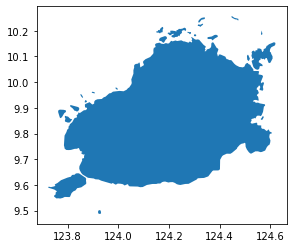

In [10]:
aoi.plot()

### Health Facilities

In [11]:
doh = gpd.read_file(os.path.join(input_dir, "doh_healthfacilities_april2020.shp"))

<AxesSubplot:>

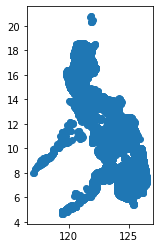

In [12]:
doh.plot()

In [13]:
doh = doh.loc[doh.province=='BOHOL'].copy()

In [14]:
doh.head()

,id,facilityco,healthfaci,typeofheal,barangay,municipali,province,region,status,address,style,geometry
14672,17134.0,DOH000000000002989,L.g. Cutamora Community Clinic,Hospital,Fatima,UBAY,BOHOL,REGION VII (CENTRAL VISAYAS),Functional,Purok 4,Hospital,POINT (124.47544 10.05558)
15381,17135.0,DOH000000000005353,Don Emilio Del Valle Memorial Hospital,Hospital,Bood,UBAY,BOHOL,REGION VII (CENTRAL VISAYAS),Functional,None,Hospital,POINT (124.47465 10.04462)
15601,19009.0,DOH000000000001864,Clarin Community Hospital,Hospital,Poblacion,CLARIN,BOHOL,REGION VII (CENTRAL VISAYAS),Functional,Poblacion,Hospital,POINT (124.02349 9.96308)
17029,17124.0,DOH000000000006827,Ubay Rural Health Unit 1,Rural Health Unit,Poblacion,UBAY,BOHOL,REGION VII (CENTRAL VISAYAS),Functional,None,Rural Health Unit,POINT (124.47443 10.05478)
17030,17125.0,DOH000000000024681,Camambugan Barangay Health Station,Barangay Health Station,Camambugan,UBAY,BOHOL,REGION VII (CENTRAL VISAYAS),Functional,Purok 4,Barangay Health Station,POINT (124.43530 10.05757)


Looking at the NHFR Excel tables received, it looks like there are three separate sheets per region (CV, Cebu, and CAR).
Load CV (Central Visaya) and try to match location data from DOH.

In [15]:
registry = pd.read_excel(os.path.join(input_dir, "NHFR_CENTRAL VISAYAS.xlsx"), "CV_7")

In [16]:
registry.columns

Index(['Health Facility Code', 'Health Facility Code Short', 'Facility Name',
       'Old Health Facility Names', 'Old Health Facility Name 2',
       'Old Health Facility Name 3', 'Health Facility Type',
       'Ownership Major Classification',
       'Ownership Sub-Classification for Government facilities',
       'Ownership Sub-Classification for private facilities',
       'Street Name and #           ', 'Building name and #', 'Region Name',
       'Region PSGC', 'Province Name', 'Province PSGC',
       'City/Municipality Name', 'City/Municipality PSGC', 'Barangay Name',
       'Barangay PSGC', 'Zip Code', 'Landline Number', 'Landline Number 2',
       'Fax Number', 'Email Address', 'Alternate Email Address',
       'Official Website', 'Facility Head: Last Name',
       'Facility Head: First Name', 'Facility Head: Middle Name',
       'Facility Head: Position', 'Hospital Licensing Status',
       'Service Capability', 'Bed Capacity'],
      dtype='object')

In [17]:
registry["Province Name"].value_counts()

CEBU               1299
BOHOL               822
NEGROS ORIENTAL     552
SIQUIJOR             67
Name: Province Name, dtype: int64

In [18]:
registry = registry.loc[registry["Province Name"]=="BOHOL"].copy()

In [19]:
registry["Health Facility Type"].value_counts()

Barangay Health Station        687
Rural Health Unit               51
Birthing Home                   51
Hospital                        16
Infirmary                        9
General Clinic Laboratory        5
COVID-19 Testing Laboratory      2
Municipal Health Office          1
Name: Health Facility Type, dtype: int64

In [20]:
len(registry), len(doh)

(822, 546)

In [21]:
registry = registry.merge(doh, left_on='Health Facility Code', right_on='facilityco', how='left')

In [22]:
registry.geometry.isna().value_counts()

False    458
True     376
Name: geometry, dtype: int64

In [23]:
registry = gpd.GeoDataFrame(registry, geometry='geometry', crs=doh.crs)

<AxesSubplot:>

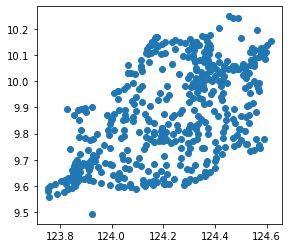

In [24]:
registry.plot()

Strategies to match location for missing facilities: look for zip codes, barangay (adm4 file), maybe geocode (not very confident on this last option)  
For now work with those that have location

In [26]:
registry = registry.loc[~registry.geometry.isna()].copy()

In [27]:
registry.reset_index(drop=True, inplace=True)

Something important to ask is whether we should be working with health stations. There way more and it might be more interesting to look at access to hospitals and primary care centers

In [28]:
registry_filter = registry.loc[registry["Health Facility Type"]!="Barangay Health Station"].copy()

### Friction Surface

In [29]:
global_friction_surface = "/home/public/Data/GLOBAL/INFRA/FRICTION_2020/2020_motorized_friction_surface.geotiff"
wp_1km = os.path.join(input_dir, "phl_ppp_2020_1km_Aggregated_UNadj.tif")

In [30]:
inG = rio.open(global_friction_surface)

In [31]:
# Clip the travel raster to AOI
out_travel_surface = os.path.join(out_folder, "travel_surface_bohol.tif")
rMisc.clipRaster(inG, aoi, out_travel_surface, bbox=False, buff=0.1)

/home/wb514197/Repos/gostrocks/src/GOSTRocks/rasterMisc.py:110: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  inD = inD.buffer(buff)


In [32]:
inP = rio.open(wp_1km)

In [33]:
# Clip the pop raster to AOI
out_pop = os.path.join(out_folder, "pop_bohol.tif")
rMisc.clipRaster(inP, aoi, out_pop, bbox=False, buff=0.1)

In [34]:
travel_surf = rio.open(out_travel_surface)
pop_surf = rio.open(out_pop)

In [35]:
out_pop_surface_std = os.path.join(out_folder, "pop_bohol_STD.tif")
rMisc.standardizeInputRasters(pop_surf, travel_surf, out_pop_surface_std, resampling_type="nearest")

[array([[[-99999., -99999., -99999., ..., -99999., -99999., -99999.],
         [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
         [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
         ...,
         [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
         [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
         [-99999., -99999., -99999., ..., -99999., -99999., -99999.]]],
       dtype=float32),
 {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': -99999.0,
  'width': 133,
  'height': 117,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(0.008333333333333333, 0.0, 123.61666666666667,
         0.0, -0.008333333333333333, 10.358333333333334)}]

In [36]:
pop_surf = rio.open(out_pop_surface_std)
pop = pop_surf.read(1, masked=True)
indices = list(np.ndindex(pop.shape))
xys = [Point(pop_surf.xy(ind[0], ind[1])) for ind in indices]
res_df = pd.DataFrame({
    'spatial_index': indices, 
    'xy': xys, 
    'pop': pop.flatten()
})
res_df['pointid'] = res_df.index

In [145]:
# create MCP object
inG_data = travel_surf.read(1) * 1000 # minutes to travel 1 meter, convert to km
# Correct no data values
inG_data[inG_data < 0] = 9999999999
# inG_data[inG_data < 0] = np.nan
mcp = graph.MCP_Geometric(inG_data)

### 1. Catchment Area

In [38]:
for idx, dest in registry.iterrows():
    dest_gdf = gpd.GeoDataFrame([dest], geometry='geometry', crs='EPSG:4326')
    res = ma.calculate_travel_time(travel_surf, mcp, dest_gdf)[0]
    res_df.loc[:,idx] = res.flatten()

/home/wb514197/.conda/envs/graph/lib/python3.7/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [39]:
res_df = res_df.loc[res_df['pop']>0].copy()
res_df = res_df.loc[~(res_df['pop'].isna())].copy()

In [40]:
# res_df.loc[:, registry.index] = res_df.loc[:, registry.index].apply(lambda x: x/60) # convert to hours

In [41]:
res_df.head()

,spatial_index,xy,pop,pointid,0,1,2,3,4,5,...,448,449,450,451,452,453,454,455,456,457
1583,"(11, 120)",POINT (124.6208333333333 10.2625),233.189651,1583,174.827661,112.596690,132.981467,126.174397,125.830508,89.194147,...,83.001395,80.219273,125.275623,124.507856,58.504034,127.471059,114.321564,97.282982,100.968181,182.230204
1676,"(12, 80)",POINT (124.2875 10.25416666666667),94.150398,1676,104.289856,70.685185,91.069961,109.733454,109.389565,44.628835,...,86.853345,57.760563,54.737817,53.970050,58.188452,97.456000,85.513612,55.371476,35.676160,140.318698
1677,"(12, 81)",POINT (124.2958333333333 10.25416666666667),362.527374,1677,103.594973,69.990302,90.375078,109.038572,108.694682,43.933953,...,86.158463,57.065681,54.042935,53.275168,56.653935,96.761117,84.818729,54.676594,34.981278,139.623816
1682,"(12, 86)",POINT (124.3375 10.25416666666667),24.213766,1682,113.083750,73.920799,94.305575,112.850695,112.506806,47.864450,...,87.198279,58.984406,63.531712,62.763945,40.853934,100.691614,88.749226,58.607090,36.106657,143.554312
1695,"(12, 99)",POINT (124.4458333333333 10.25416666666667),176.003372,1695,123.820979,79.887000,100.271776,115.157095,114.813206,52.366185,...,89.038979,61.290806,74.268941,73.501174,2.474874,106.657815,94.715427,64.573291,45.570285,149.520514


In [42]:
res_df.loc[:, "closest_idx"] = res_df[registry.index].idxmin(axis=1) # get id of health facility that yields the minimum travel time
res_df.loc[:, "closest_idx_filter"] = res_df[registry_filter.index].idxmin(axis=1) # same but without health stations

In [43]:
res_df.loc[:,'xy'] = res_df['xy'].apply(Point)

In [67]:
res_gdf = gpd.GeoDataFrame(res_df, geometry='xy', crs='EPSG:4326')

In [68]:
#libraries for plotting maps
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rasterio.plot import plotting_extent
import contextily as ctx

### Save some maps
Issue here is that the colors are being repeated and grouped

In [134]:
graphs_dir = os.path.join(repo_dir, 'output')
if not os.path.exists(graphs_dir):
    os.mkdir(graphs_dir)

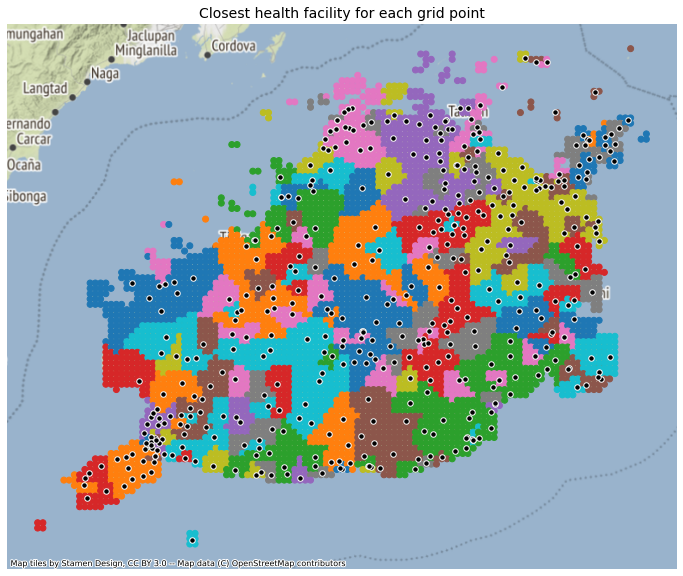

In [135]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
ax.set_title("Closest health facility for each grid point", fontsize=14)
res_gdf.plot('closest_idx', ax = ax, categorical=True, legend=False)
plt.axis('off')
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)
registry.plot(ax=ax, facecolor='black', edgecolor='white', markersize=30, alpha=1)
plt.savefig(os.path.join(graphs_dir, "Bohol_Catchment_AllHealth.png"), dpi=300, bbox_inches='tight', facecolor='white')

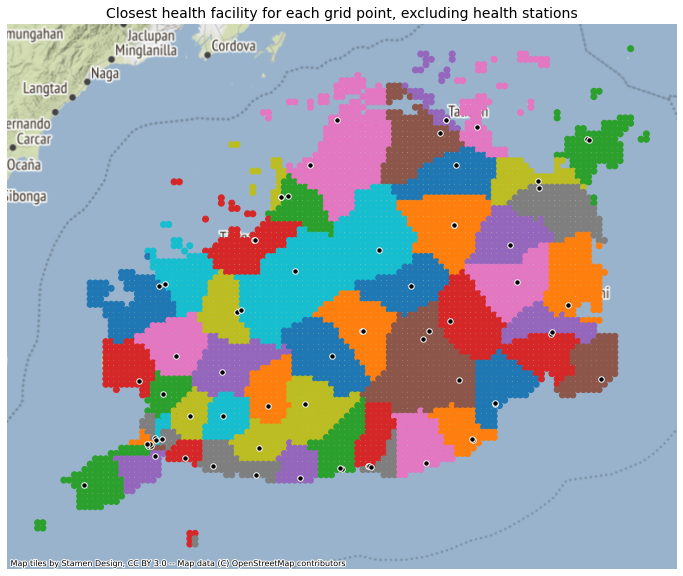

In [136]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
ax.set_title("Closest health facility for each grid point, excluding health stations", fontsize=14)
res_gdf.plot('closest_idx_filter', ax = ax, categorical=True, legend=False)
plt.axis('off')
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)
registry_filter.plot(ax=ax, facecolor='black', edgecolor='white', markersize=30, alpha=1)
plt.savefig(os.path.join(graphs_dir, "Bohol_Catchment_NoStations.png"), dpi=300, bbox_inches='tight', facecolor='white')

### Calculate travel time to nearest health facility (excluding stations)

In [146]:
pop_surf = rio.open(out_pop_surface_std)
pop = pop_surf.read(1, masked=True)
indices = list(np.ndindex(pop.shape))
xys = [Point(pop_surf.xy(ind[0], ind[1])) for ind in indices]
res_df = pd.DataFrame({
    'spatial_index': indices, 
    'xy': xys, 
    'pop': pop.flatten()
})
res_df['pointid'] = res_df.index

In [147]:
res_min = ma.calculate_travel_time(travel_surf, mcp, registry_filter)[0]

In [148]:
res_df.loc[:, f"tt_health"] = res_min.flatten()

In [149]:
res_df = res_df.loc[res_df['pop']>0].copy()
res_df = res_df.loc[~(res_df['pop'].isna())].copy()

In [150]:
res_df.head()

,spatial_index,xy,pop,pointid,tt_health
1583,"(11, 120)",POINT (124.6208333333333 10.2625),233.189651,1583,54.864499
1676,"(12, 80)",POINT (124.2875 10.25416666666667),94.150398,1676,35.676160
1677,"(12, 81)",POINT (124.2958333333333 10.25416666666667),362.527374,1677,34.981278
1682,"(12, 86)",POINT (124.3375 10.25416666666667),24.213766,1682,36.106657
1695,"(12, 99)",POINT (124.4458333333333 10.25416666666667),176.003372,1695,39.898555


In [151]:
res_df.loc[:,'xy'] = res_df['xy'].apply(Point)
res_gdf_tt = gpd.GeoDataFrame(res_df, geometry='xy', crs='EPSG:4326')

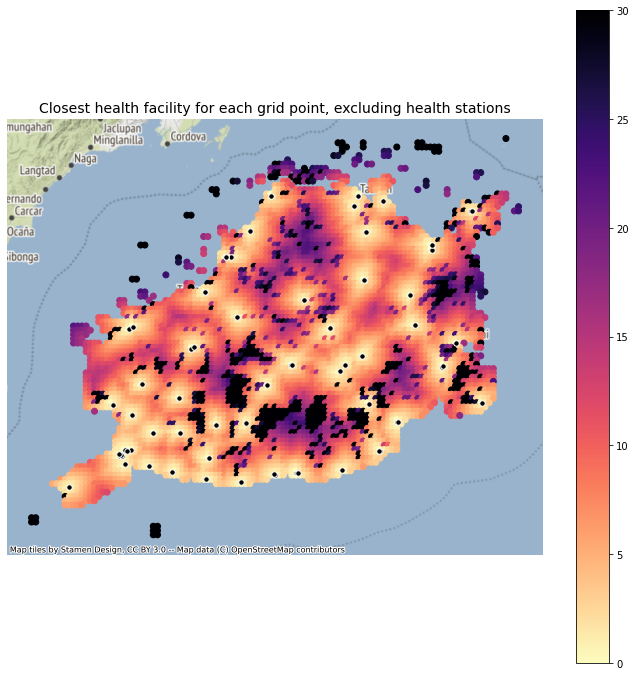

In [157]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
ax.set_title("Closest health facility for each grid point, excluding health stations", fontsize=14)
res_gdf_tt.plot('tt_health', ax = ax, categorical=False, legend=True, vmin=0, vmax=30, cmap='magma_r')
plt.axis('off')
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)
registry_filter.plot(ax=ax, facecolor='black', edgecolor='white', markersize=30, alpha=1)
plt.savefig(os.path.join(graphs_dir, "Bohol_TravelTime_NoStations.png"), dpi=300, bbox_inches='tight', facecolor='white')

These values seem really low! Maybe becuase it's an island? We need to do some checks...

In [129]:
# res_min[res_min>99999999] = np.nan
# res_min = res_min/60

In [130]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

In [155]:
# figsize = (12,12)
# fig, ax = plt.subplots(1, 1,  figsize = figsize)
# ax.set_title("Travel time to nearest health facility", fontsize=14)

# plt.axis('off')
# ext = plotting_extent(pop_surf)

# im = ax.imshow(res_min, vmin=0, vmax=1, cmap='magma_r', extent=ext)
# # im = ax.imshow(res_min, norm=colors.PowerNorm(gamma=0.05), cmap='YlOrRd', extent=ext)
# # im = ax.imshow(res_min, cmap=newcmp, extent=ext)

# # ctx.add_basemap(ax, source=ctx.providers.Esri.WorldShadedRelief, crs='EPSG:4326', zorder=-10)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)

# registry_filter.plot(ax=ax, facecolor='black', edgecolor='white', markersize=50, alpha=1)
# aoi.plot(ax=ax, facecolor='none', edgecolor='black')

# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size="4%", pad=0.1)
# cb = fig.colorbar(im, cax=cax, orientation='vertical')

# plt.savefig(os.path.join(graphs_dir, "Bohol_TravelTime_NoStations.png"), dpi=300, bbox_inches='tight', facecolor='white')
# # fig = ax.get_figure()
# # fig.savefig(
# #     os.path.join(out_folder, "MNG_AirportTravelTime.png"),
# #     facecolor='white', edgecolor='none'
# # )

Save some output data to check values

In [77]:
registry.loc[:, "idx"] = registry.index

In [79]:
registry.to_file(os.path.join(out_folder, "registry.shp"))

/home/wb514197/.conda/envs/graph/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


In [83]:
raster_path = out_pop_surface_std

In [120]:
res_gdf.loc[:, "geometry"] = res_gdf.loc[:, "xy"]

In [121]:
res_gdf.loc[:, "closest_idx"] = res_gdf.loc[:, "closest_idx"].astype('int32')

In [102]:
aggregator.rasterize_gdf(res_gdf, 'closest_idx', raster_path, os.path.join(out_folder, "closest_idx_.tif"), nodata=-1)